In [1]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/No estructurados/Practica/data/train'
test_dir= '/content/drive/MyDrive/No estructurados/Practica/data/test'
val_dir = '/content/drive/MyDrive/No estructurados/Practica/data/valid'

### Cargamos los datasets de imagenes de entrenamiento, test y validación

In [4]:
train_datagen = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)

train_dg = train_datagen.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = (299, 299),
                                    batch_size = 128,
                                    shuffle = True,
                                    seed = 42)
val_datagen = ImageDataGenerator()
validation_dg = val_datagen.flow_from_directory(val_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 128,
                                      shuffle = False,
                                      seed = 42)
testing_dg = val_datagen.flow_from_directory(test_dir,
                                      class_mode = "categorical",
                                      target_size = (299, 299),
                                      batch_size = 128,
                                      shuffle = False,
                                      seed = 42)

Found 13529 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


### Creamos el Modelo. Usamos EfficientNetBO con pesos de ImageNet

In [5]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Congelamos todas las capas menos las 3 ultimas
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Clasificador
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(100, activation="softmax")(x)


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


### Entrenamos el modelo

In [7]:
es =    EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 2,
                               restore_best_weights = True)
filename = 'model.transfer_learning_v2.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(
      train_dg,
      epochs=30,
      validation_data = validation_dg,
    callbacks=[
       es,
       checkpoint,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min'),

    ]
)

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 0.8706 - accuracy: 0.7743 
Epoch 1: val_loss improved from inf to 0.24839, saving model to model.transfer_learning_v2.keras
106/106 [==============================] - 4640s 44s/step - loss: 0.8706 - accuracy: 0.7743 - val_loss: 0.2484 - val_accuracy: 0.9220 - lr: 0.0050
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9136 
Epoch 2: val_loss improved from 0.24839 to 0.18540, saving model to model.transfer_learning_v2.keras
106/106 [==============================] - 2590s 24s/step - loss: 0.2852 - accuracy: 0.9136 - val_loss: 0.1854 - val_accuracy: 0.9420 - lr: 0.0050
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9413 
Epoch 3: val_loss improved from 0.18540 to 0.15468, saving model to model.transfer_learning_v2.keras
106/106 [==============================] - 2575s 24s/step - loss: 0.1961 - accuracy: 0.9413 - val_loss: 0.1547 - val

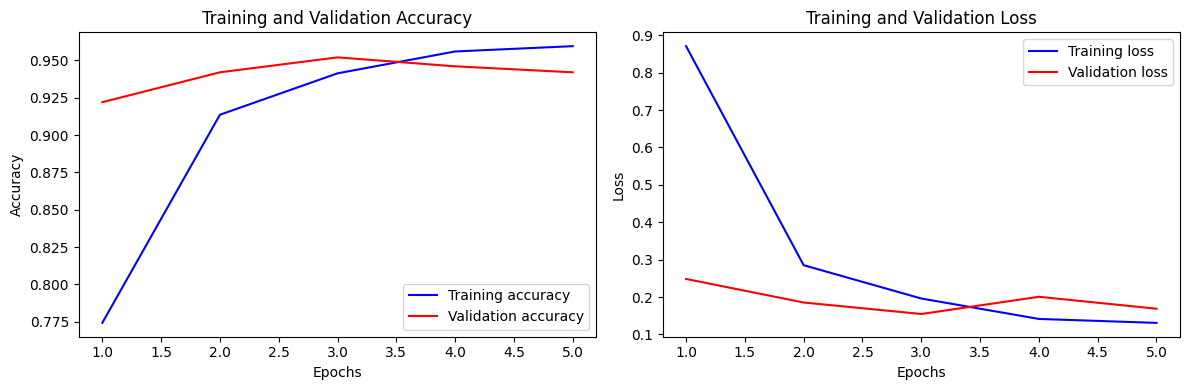

In [8]:
# Extracting training and validation metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
predictions=model.evaluate(testing_dg)

4/4 [==============================] - 122s 33s/step - loss: 0.0972 - accuracy: 0.9660


In [12]:
true_labels = testing_dg.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(testing_dg), axis=1)

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=testing_dg.class_indices.keys()))

4/4 [==============================] - 86s 20s/step
Classification Report:
                        precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       0.62      1.00      0.77         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      0.80      0.89         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.0